In [16]:
import yfinance as yf
from yahoo_fin import options
from yahoo_fin import stock_info as si
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime


In [17]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

In [18]:
# Free interest rate is taken as 10 year bond rate. ^TNX
print(yf.Ticker("^TNX").info)

{'exchange': 'NYB', 'shortName': 'CBOE Interest Rate 10 Year T No', 'longName': 'Treasury Yield 10 Years', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-18000000', 'quoteType': 'INDEX', 'symbol': '^TNX', 'messageBoardId': 'finmb_INDEXTNX', 'market': 'us24_market', 'previousClose': 3.684, 'regularMarketOpen': 3.647, 'twoHundredDayAverage': 3.173215, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 3.697, 'navPrice': None, 'averageDailyVolume10Day': 0, 'totalAssets': None, 'regularMarketPreviousClose': 3.684, 'fiftyDayAverage': 3.8359, 'trailingAnnualDividendRate': None, 'open': 3.647, 'toCurrency': None, 'averageVolume10days': 0, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 3.6209998, 'priceHint': 4, 'currency': 'U

In [19]:
# Objective
tickers=["SI","AAPL","NFLX","TSLA","GOOGL","META","MSFT"]


In [20]:
risk_free_rate=0.035

In [21]:
# Get the current market price
def Currenct_Market_Price(tickers):
    current_price=[]
    for ticker in tickers:  
        ticker_yahoo = yf.Ticker(ticker)
        data = ticker_yahoo.history()
        last_quote = data['Close'].iloc[-1]
        current_price=np.append(current_price,last_quote)
        print(ticker, last_quote)
    return current_price
    

In [22]:
def Calculate_sd(tickers):
    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    sd_list=np.array(0,dtype=np.float64)
    for ticker in tickers:
        history=yf.download(ticker,start=one_year_ago, end=today, interval="1d")   
        history['Change']=history['Adj Close'].pct_change(1)
        sigma = np.sqrt(252) * history['Change'].std()
        print(sigma)
        sd_list=np.append(sd_list,sigma)
    sd_list=np.delete(sd_list,0)
    return sd_list

In [23]:
Calculate_sd(tickers)

[*********************100%***********************]  1 of 1 completed
1.0623010034764047
[*********************100%***********************]  1 of 1 completed
0.3545338786028173
[*********************100%***********************]  1 of 1 completed
0.6973884363601764
[*********************100%***********************]  1 of 1 completed
0.6486440642562359
[*********************100%***********************]  1 of 1 completed
0.38404381619588296
[*********************100%***********************]  1 of 1 completed
0.6422462873116831
[*********************100%***********************]  1 of 1 completed
0.35203603875770745


array([1.062301  , 0.35453388, 0.69738844, 0.64864406, 0.38404382,
       0.64224629, 0.35203604])

In [13]:
def Calculate_fair_price(tickers,time_to_expire,risk_free):
    result=np.array(0)
    market_price=Currenct_Market_Price(tickers)
    sd=Calculate_sd(tickers)
    for ticker in range(len(tickers)):
        chain = options.get_options_chain(tickers[ticker])
        fair_price=np.array(0,np.float64)
        for i in range(len(chain["calls"])):
            fair_price=np.append(fair_price,BS_CALL(market_price[ticker],chain["calls"]["Strike"][i],time_to_expire,risk_free,sd[ticker]))
        fair_price=np.delete(fair_price,0)
        chain["calls"]["Fair Value"]=fair_price
        result=np.append(result,chain["calls"])
    return result

In [ ]:
yoyo=Calculate_fair_price(tickers,0.008,0.035)
yoyo

In [24]:
def Calculate_fair_price_of_single_stock(tickers,time_to_expire,risk_free):
    market_price=Currenct_Market_Price(tickers)
    sd=Calculate_sd(tickers)
    chain = options.get_options_chain(tickers[0])
    fair_price=np.array(0,np.float64)
    bid_ratio=np.array(0,np.float64)
    ask_ratio=np.array(0,np.float64)
    for i in range(len(chain["calls"])):
        fair_price=np.append(fair_price,BS_CALL(market_price[0],chain["calls"]["Strike"][i],time_to_expire,risk_free,sd[0]))
    fair_price=np.delete(fair_price,0)
    chain["calls"]["Fair Value"]=fair_price
    chain["calls"].drop('Last Trade Date', inplace=True, axis=1)
    chain["calls"].drop('Volume', inplace=True, axis=1)
    chain["calls"].drop('Open Interest', inplace=True, axis=1)
    chain["calls"].drop('Change', inplace=True, axis=1)
    chain["calls"].drop('% Change', inplace=True, axis=1)
    chain["calls"]["Bid Ratio"]=chain["calls"]["Fair Value"]/chain["calls"]["Bid"]
    chain["calls"]["Ask Ratio"]=chain["calls"]["Fair Value"]/chain["calls"]["Ask"]
    chain["calls"]["Fair Ratio"]=chain["calls"]["Fair Value"]/chain["calls"]["Fair Value"]
    return chain["calls"]

In [25]:
fair_Price_of_aapl=Calculate_fair_price_of_single_stock(["GOOGL"],0.008,0.0365)

GOOGL 89.8499984741211
[*********************100%***********************]  1 of 1 completed
0.3840470023330864


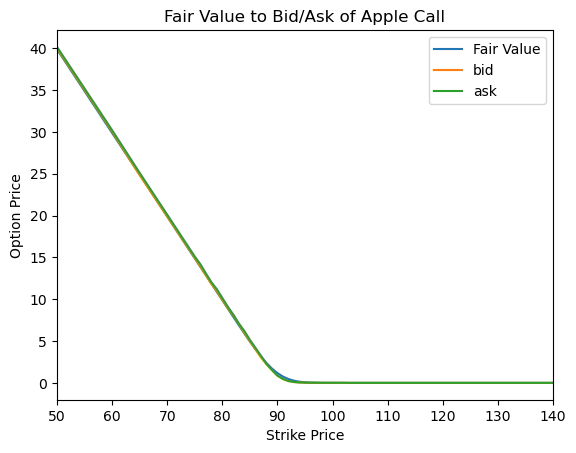

In [26]:
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Fair Value"],label="Fair Value")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Bid"],label="bid")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Ask"],label="ask")
# naming the x axis
plt.xlabel('Strike Price')
# naming the y axis
plt.ylabel('Option Price')
  
# giving a title to my graph
plt.title('Fair Value to Bid/Ask of Apple Call')
plt.xlim(50,140)
# function to show the plot
plt.legend()
plt.show()

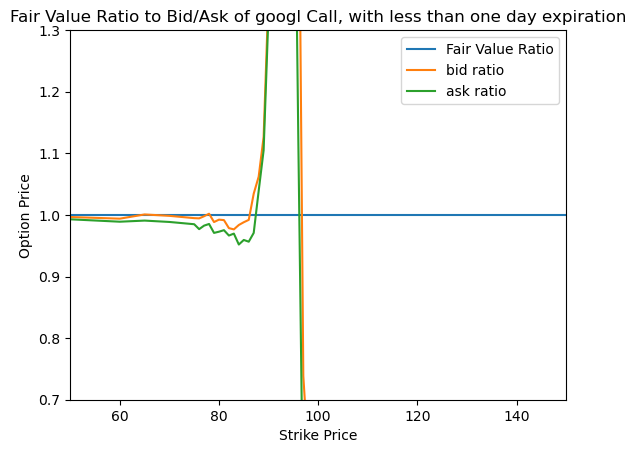

In [28]:
plt.cla()
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Fair Ratio"],label="Fair Value Ratio")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Bid Ratio"],label="bid ratio")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Ask Ratio"],label="ask ratio")
# naming the x axis
plt.xlabel('Strike Price')
# naming the y axis
plt.ylabel('Option Price')
  
# giving a title to my graph
plt.title('Fair Value Ratio to Bid/Ask of googl Call, with less than one day expiration')
plt.xlim(50,150)
plt.ylim(0.7,1.3)
# function to show the plot
plt.legend()
plt.show()

<h1> Try another stock with risky Behavior
    

In [ ]:
fair_Price_of_aapl=Calculate_fair_price_of_single_stock(["SI"],0.008,0.0365)


In [ ]:
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Fair Value"],label="Fair Value")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Bid"],label="bid")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Ask"],label="ask")
# naming the x axis
plt.xlabel('Strike Price')
# naming the y axis
plt.ylabel('Option Price')
  
# giving a title to my graph
plt.title('Fair Value to Bid/Ask of Silvergate Call')
plt.xlim(14,20)
# function to show the plot
plt.legend()
plt.show()

In [ ]:
plt.cla()
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Fair Ratio"],label="Fair Value Ratio")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Bid Ratio"],label="bid ratio")
plt.plot(fair_Price_of_aapl["Strike"], fair_Price_of_aapl["Ask Ratio"],label="ask ratio")
# naming the x axis
plt.xlabel('Strike Price')
# naming the y axis
plt.ylabel('Option Price')
  
# giving a title to my graph
plt.title('Fair Value Ratio to Bid/Ask of Silvergate Call')
plt.xlim(14,20)
plt.ylim(0.7,1.3)
# function to show the plot
plt.legend()
plt.show()